# Vessel segmentation in retina fundus images
<img src="images/21_training.png" width="250" height="250" align="right">
The goal of this assignment is to develop an algorithm for automatic segmentation of vessels in retina fundus images using 
feature classification and morphological filtering.


## Teaching assistants

- Bart Liefers: bart.liefers@radboudumc.nl
- Francesco Ciompi: francesco.ciompi@radboudumc.nl

## Students
Please fill in this cell with your name and e-mail address. This information will be used to grade your assignment.

* Brian Westerweel, email address: b.westerweel@student.ru.nl
* Jeffrey Luppes, email address: j.luppes@student.ru.nl

## Instructions

* Groups: You should work in pairs or alone. Working in groups of 2 is preferable. Try to team up with someone! 
* Deadline for this assignment: 
 * Sunday February 18th at 23:59h.
 * 5 points (maximum grade = 100 points) penalization per day after deadline
* Submit your **fully executed** notebook to grand-challenge.org (more details about this later in this notebook). 

This notebooks contains cells with snippets of code that we provide in order to load and visualize data, but also some convenience functions that could be useful to develop your assignment. We also provide templates for functions that have to be implemented, with a given list of input variables and some output variables. **Feel free to modify the input and output variables to adapt them to your favourite implementation.** However, this should at least provide the outputs required to develop the rest of the notebook.

Your submission should contain the **fully executed** notebook with **your code** implemented, as well as **your answers** to questions, which will be used to grade your assignment.

## Clinical background

Retinal vessel segmentation and delineation of morphological attributes of retinal blood vessels, such as length, width, tortuosity, branching patterns and angles are utilized for the diagnosis, screening, treatment, and evaluation of various cardiovascular and ophthalmologic diseases such as diabetes, hypertension, arteriosclerosis and chorodial neovascularization.

Automatic detection and analysis of the vasculature can assist in the implementation of screening programs for diabetic retinopathy, can aid research on the relationship between vessel tortuosity and hypertensive retinopathy, vessel diameter measurement in relation with diagnosis of hypertension, and computer-assisted laser surgery.

Automatic generation of retinal maps and extraction of branch points have been used for temporal or multimodal image registration, retinal image mosaic synthesis. Moreover, the retinal vascular tree is found to be unique for each individual and can be used for biometric identification.

## Data 

In this assignment, we are going to develop a system to automatically **segment vessels** in human retina fundus images. For this purpose, we are going to use data from the publicly available DRIVE dataset (http://www.isi.uu.nl/Research/Databases/DRIVE/).
The DRIVE dataset consists of 40 images, 20 used for training and 20 used for testing. Each case contains:
* a fundus (RGB) image
* a binary mask, which indicates the area of the image that has to be analyzed (removing black background)
* manual annotations of retinal vessels, provided as a binary map

## Tasks for this assignment
<img src="images/submission.png" width="420" align="right">
1. Develop a system to segment vessels in retinal images in this notebook. You will have to submit this notebook with your code, which we will run and evaluate, together with the results of the segmentation.
2. Use the training set provided with the DRIVE dataset to train/tune the parameters of your system. You cannot use data from the test set available on the DRIVE website, nor from other datasets. 
3. Apply it to the test dataset and generate a binary map of the segmented vessel. The map must have the same size as the input image.
4. Submit the results of your algorithm to the mini-challenge framework. You can create a zip-file by running the corresponding cell at the end of the notebook. You will have to **submit** this file to the mini-challenge framework (https://drive.grand-challenge.org/). In order to submit results, click on the **Submit** tab on grand-challenge, then click on the **green button** to select your .zip "Predictions File" and submit it. You can monitor the execution of your submission by clicking on the link at the end of the page. Note that while grading your assignment, we will run your implementation and reproduce your results. Any significant discrepancy between the results submitted to the mini-challenge framework and the one computed using this notebook will be penalized and discussed with the student. **Note**: It is allowed to submit multiple times, checking the performance of different results of your algorithm. In order to keep track of your submissions, you can add a comment when you submit your .zip file.
5. Once you have completed your assignment, submit this notebook via grand-challenge.org, by clicking on the "Jupyter Notebook" submission button. 

## Implementation 

### Mandatory task: Max 60 pts
You will be asked to implement your vessel segmentation system based on **pixel classification based on texture analysis**.
For this purpose, you can use the following publications as reference:

* [1] M. Niemeijer et al. "Comparative study of retinal vessel segmentation methods on a new publicly available database" (the paper suggested last week)
* [2] Y. Yang et al., "An automatic hybrid method for retinal blood vessel extraction"
* [3] M.M. Fraz et al., "Blood vessel segmentation methodologies in retinal images - A survey"

The first paper explains how to segment retinal vessels using pixel classification.
In this assignment, you should implement the solution based on pixel classification as is explained in section 2.3.5 of the first paper. 
This part of the assignment is **mandatory**. 

### Optional task: Max 40pts
Next, you could try to **improve the segmentation** result. The goal is to design the best CAD system for vessel segmentation and validate its performance on the DRIVE dataset! A few ideas to improve the system are:

* More features (Directional filters, local binary patterns, Gabor filters, etc.). Get creative!
* Postprocessing to improve the results using morphological filtering
* More training samples
* etc.

This second part is **optional** and will be evaluated to give some extra points to your grade.

# Overview
A method based on texture analysis and pixel classification, requires a set of labeled samples, for which the correct label is known. We call this a *training set*. In order to build a training set, positive (vessel) and negative (non-vessel) samples have to be extracted from the images in the training set. This set will be used to classify new (test) samples, using for example a **nearest-neighbour** strategy for assigning labels. To objectively validate different methods, we will compare the results of your method with reference data (manual annotations). The outline of the approach you are about the implement is:
1. Load data: download the data, import and convert to numpy, inspect the available annotations.
2. Feature extraction: Implement texture analysis to extract features from the images and create a training set.
3. Train the classifier: for example a nearest-neighbour classifier.
4. Test the classifier: apply the classifier to new data to obtain a new vessel map.
5. Submit your results: submit the output of your algorithm to grand-challenge, where it will be evaluated and compared to other submissions.


## Step 1: Load data

Let's get started by importing libraries needed for this assignment:

In [1]:
import os
import shutil
import numpy as np
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import KNeighborsClassifier
import scipy.signal

Now, let's load the training data (images, masks and labels) into memory.
You should be able to work on Cartesius at this point. In this case, the data is available in a project folder on surfsara.
Otherwise, you can also work on your laptop, and you have to download the data yourself.
We make two different cells to cover both options. Please only execute the appropriate one below.

## If the Jupter server runs on Cartesius

In [2]:
# Path that points to the local copy of training data
data_folder = '/projects/0/ismi2018/DRIVE'

## If the Jupyter server runs on your computer

In [3]:
# Script to download the dataset to your local computer
import requests
from tqdm import tqdm_notebook
import zipfile
link = 'https://surfdrive.surf.nl/files/index.php/s/lgIuEFPPETtM2ZP/download'
file_name = "DRIVE.zip"
with open(file_name, "wb") as f:
        response = requests.get(link, stream=True)
        total_length = response.headers.get('content-length')
        if total_length is None: # no content length header
            f.write(response.content)
        else:
            dl = 0
            total_length = int(total_length)
            for data in tqdm_notebook(response.iter_content(chunk_size=4096), desc='Downloading data'):
                dl += len(data)
                f.write(data)
with zipfile.ZipFile(file_name,"r") as zip_ref:
    zip_ref.extractall("./")
os.remove(file_name)
data_folder = 'DRIVE'

Now that the data is on the machine you are using, you can continue working on this notebook.

In [4]:
def get_file_list(path, ext=''):
    return sorted([os.path.join(path, f) for f in os.listdir(path) if f.endswith(ext)])

def load_img(path):
    return np.array(Image.open(path))

train_img_files = get_file_list(os.path.join(data_folder, 'training', 'images'), 'tif')
train_msk_files = get_file_list(os.path.join(data_folder, 'training', 'mask'), 'gif')
train_lbl_files = get_file_list(os.path.join(data_folder, 'training', '1st_manual'), 'gif')

train_imgs = [load_img(f) for f in train_img_files]
train_msks = [load_img(f) for f in train_msk_files]
train_lbls = [load_img(f) for f in train_lbl_files]

Define a function to visualize (1) the fundus image, (2) the binary mask, (3) the manual annotation. Notice the use of the argument ```cmap``` to change the ```colormap``` of the visualization. 

In [5]:
def show_image(img, msk, lbl):
    matplotlib.rcParams['figure.figsize'] = (20, 12)
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('RGB image')
    plt.subplot(1,3,2)
    plt.imshow(msk, cmap='gray')
    plt.title('Mask')
    plt.subplot(1,3,3)
    plt.imshow(lbl, cmap='gray')
    plt.title('Manual annotation')
    plt.show()

Show some images in the training set using the function defined above. Try setting a few values for ```i```.

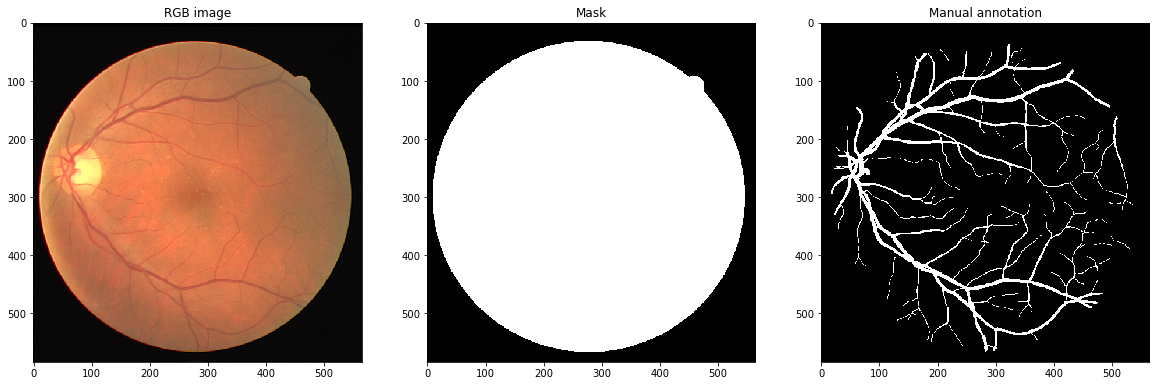

In [6]:
i = None # Try some values here    
show_image(train_imgs[0], train_msks[0], train_lbls[0])

## Step 2: Feature extraction

### Create a Gaussian filter kernel

The system described in paper [1] uses filters based on Gaussian and derivative of Gaussian functions. Now we will create a two-dimensional Gaussian filter kernel that can be used the extract features from an image. 
The part of code that you will implement to create the Gaussian kernel is in the next cell, followed by a piece of code to visualize the Gaussian kernel.

**Note**. If you completed the first assignment, you have implemented this function already. You can reuse the one you defined in the first assignment.

In [7]:
import math

def gaussian_kernel_2d(sigma, x0=0, y0=0, size_sigma=3):
    '''
        Computes a 2D Gaussian kernel with a given sigma (in pixels), centered at x0, y0
        The size of the kernel can be set as a multiple of the sigma
    '''
    xlen = int(math.ceil(2*size_sigma*sigma)+1) #with parameterization
    ylen = int(math.ceil(2*size_sigma*sigma)+1)
    x = np.tile(np.linspace(0,xlen,num = xlen)-xlen/2.0,(xlen,1)) # matrix of x coordinates of the filter
    y = np.transpose(np.tile(np.linspace(0,ylen,num = ylen)-ylen/2.0,(ylen,1))) # matrix of x coordinates of the filter
    return (1/(2*math.pi*sigma**2))*math.e**(-((x**2+y**2)/(2*sigma**2))) #the formula from assignment 1

In [8]:
def visualize_gaussian_kernel(gaussian_kernel):
    ''' 
        Visualizes a Gaussian kernel
    '''    
    fig = plt.figure()
    ax = Axes3D(fig)
    y_dim, x_dim = gaussian_kernel.shape
    sx = x_dim // 2
    sy = y_dim // 2
    x, y = np.meshgrid(range(-sx, sx + 1), range(-sy, sy + 1))
    ax.plot_surface(x, y, gaussian_kernel, rstride=1, cstride=1, cmap='jet')
    plt.show()

The following code will help you create the Gaussian filter kernel by visualizing it in 3D. 
It will show the Gaussian filter kernel you defined in the function above.
Try changing sigma to see the kernel at different scales. With `size_sigma=3` you should be able to see the 'interesting' part of the gaussian function.

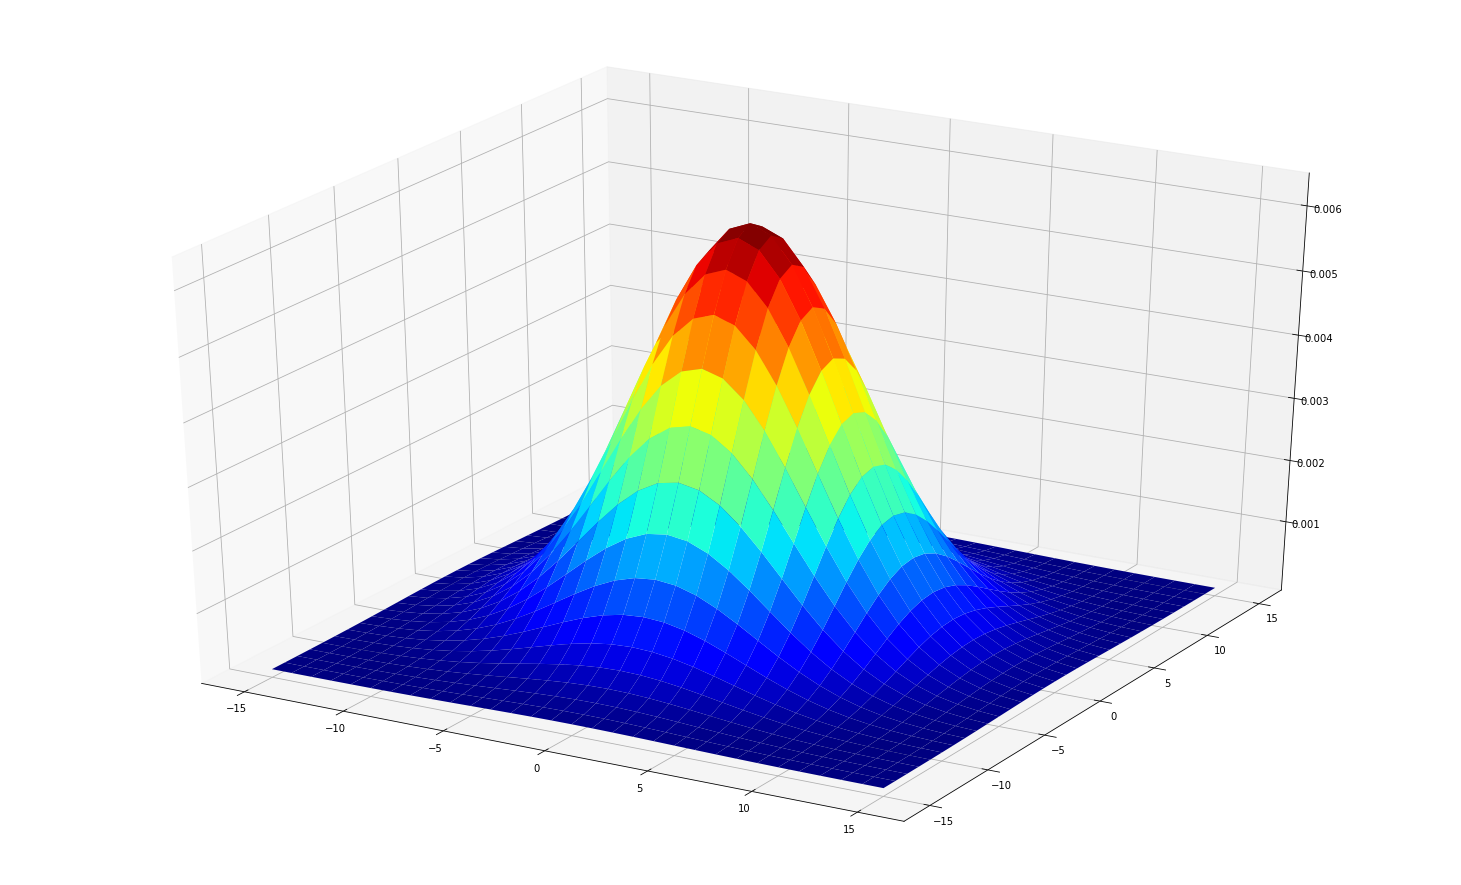

In [9]:
sigma = 5 # Try some values here
gaussian_kernel = gaussian_kernel_2d(sigma, x0=0, y0=0, size_sigma=3)
visualize_gaussian_kernel(gaussian_kernel)

### Collect features

The next function you will implement is a *feature extractor* that will extract features from an image. You will have to decide what filters, or texture analysis operators, will be used to describe the appearance of pixels. 

In order to define the number of features, consider the approach that you are going to implement. If based on paper [1], several filters based on a Gaussian kernel will be used, at several scales. 

Suggested features: 
- Gaussians at different scales
- Derivatives of Gaussians at different scales and angles
- Second derivatives at different scales and angles
    


Define your feature extraction function here:

Suggested functions to use
 - ```gaussian_kernel_2d``` (your own implementation!)
 - ```np.gradient```
 - ```scipy.signal.fftconvolve```


In [10]:
def extract_features(img):
    """
        Computes features from a give input image.
        returns a Python list of feature maps (numpy arrays, the same size as the image)
        that contain the result of the convolution of each filter with the input image.
        
        As mentioned in the lecture, given the input image 'img', only the green channel
        is typically used in retina fundus image analysis. Therefore, the green channel
        is extracted, and you can use it as input for all subsequent steps in this function.
    """    
    img_green = img[:,:,1]
    # the first feature element is the green channel itself    
    features = [img_green]
    
    sigmas = [1,2,4,8,16]
    for s in sigmas:
        g = gaussian_kernel_2d(s, x0=0, y0=0, size_sigma=3)
        features.append(scipy.signal.fftconvolve(img_green, g, mode='same'))
        features.append(scipy.signal.fftconvolve(img_green, np.gradient(g,axis=0), mode='same'))
        features.append(scipy.signal.fftconvolve(img_green, np.gradient(g,axis=1), mode='same'))
        features.append(scipy.signal.fftconvolve(img_green, np.gradient(np.gradient(g,axis=0),axis=0), mode='same'))
        features.append(scipy.signal.fftconvolve(img_green, np.gradient(np.gradient(g,axis=1),axis=1), mode='same'))
        features.append(scipy.signal.fftconvolve(img_green, np.gradient(np.gradient(g,axis=1),axis=0), mode='same'))
        
   
    return features

You can visualize the output of your feature extraction function here:

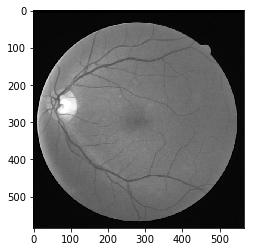

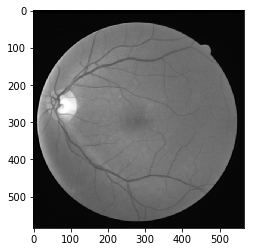

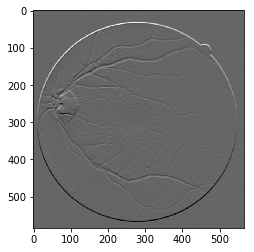

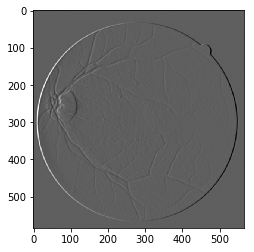

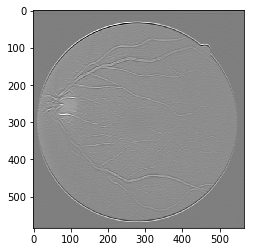

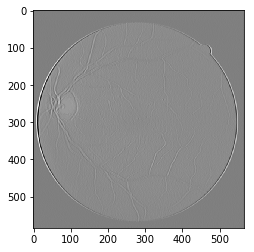

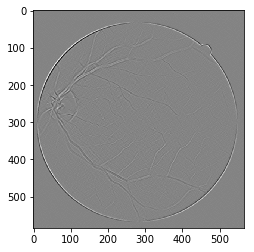

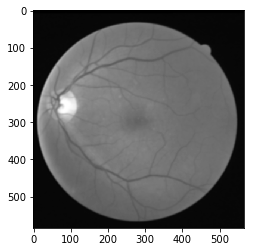

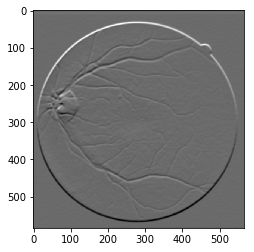

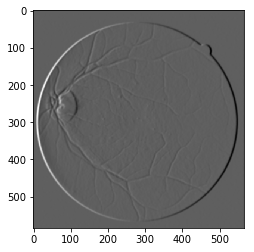

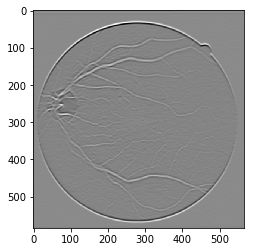

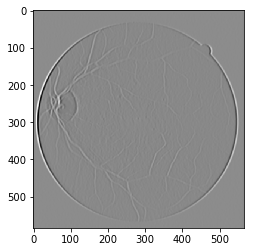

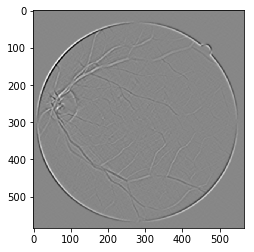

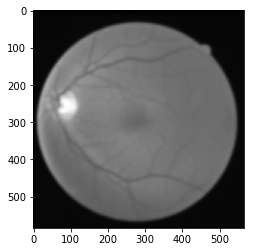

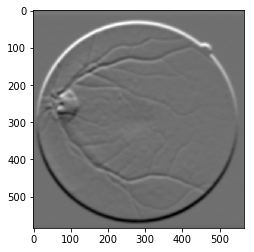

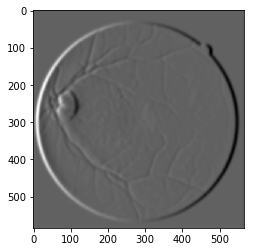

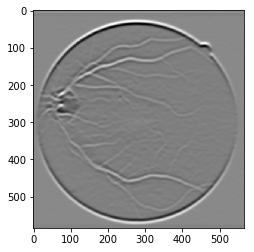

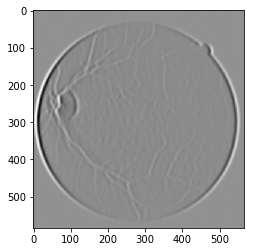

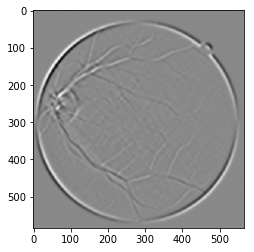

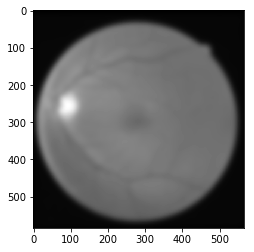

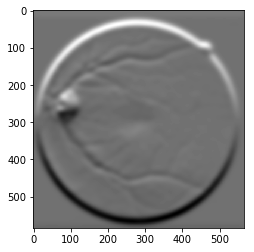

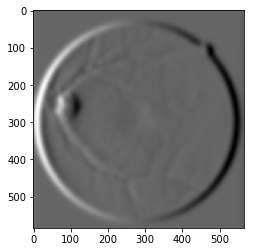

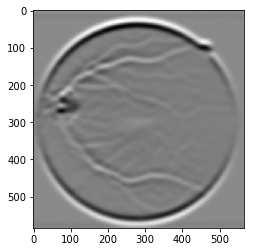

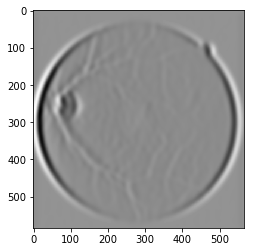

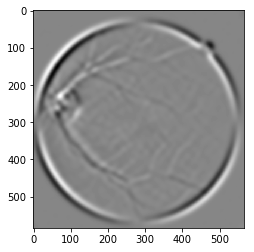

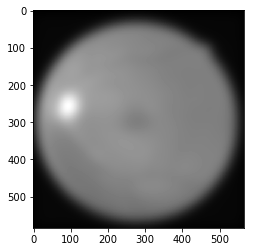

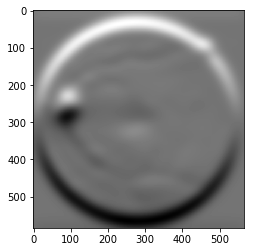

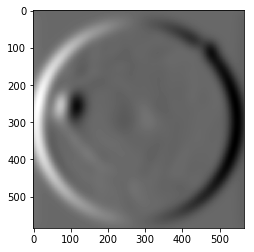

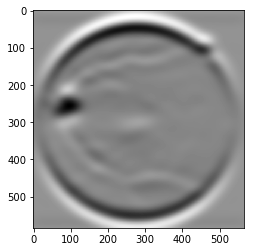

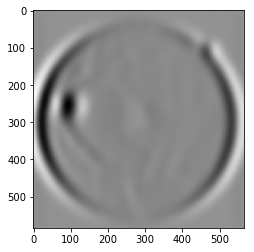

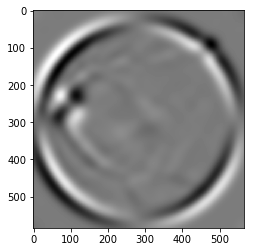

In [11]:
i = 0 # select the image in the training set
img = train_imgs[i]
features = extract_features(img)
matplotlib.rcParams['figure.figsize'] = (4, 4)
for f in features:
    plt.imshow(f, cmap='gray')
    plt.show()

<p style="color:blue">Q: How many features does your `extract_features` function generate? Explain where these features come from.</p>

<p style="green">Answer:</p>

It contains 31 features -  The first is from the green channel itself, then for each image:


* the gaussian is applied to the image.
* gy is taken
* gx is taken
* gxx is taken
* gxy is taken 
* gyy is taken

Which results in 5 (because there are five sigmas) * 6 (because there are six transformations)  = 30. Adding the basic green channel as another feature results in 31.



### Generate training data

We have read images, masks and manual annotations from the training set already:
* train_imgs (images)
* train_msks (masks)
* train_lbls (labels)

Now, we initialize the numpy arrays that will contain training **samples (x)** and corresponding training **labels (y)**. The matrix `x_train` will contain the features of each pixel in the training set, one sample per row, and one feature per column. The vector `y_train` will contain the corresponding label of each training sample. 

In [12]:
''' 
Pick a reasonable number for n_samples_per_class_per_image. 
More samples will likely result in better performance, but may make your method slow
10 samples per class per image is probably the minimum you need for some indicative results
if you want state of the art, you can take up to 2000 or more samples, 
but beware that this may result in long processing times
'''
n_samples_per_class_per_image = 2000
n_classes = 2 # How many classes?
n_features = 31 # How many features?

assert n_samples_per_class_per_image is not None
assert n_classes is not None
assert n_features is not None

vector_size = n_classes * n_samples_per_class_per_image # * len(train_imgs)

# x_train will contain the vector of features, extracted at <vector_size> locations in the training set
x_train = np.zeros((vector_size, n_features))
# y_train will contain the corresponding labels
y_train = np.zeros(vector_size)

The following function is useful when you want to collect samples randomly selected from a given binary mask, for example when you want to obtain positive and negative samples from a segmentation map. In the case of vessel segmentation, this function can be used to obtain a given number of coordinates that contain pixels labeled as vessel or non-vessel. 

In [13]:
def get_random_indices(array, n):
    '''
    returns n indices (as a tuple of x-coords and y-coords) where the array is True
    '''
    x, y = np.where(array)
    ixs = np.random.choice(len(x), size=n, replace=False)
    return x[ixs], y[ixs]

The following piece of code will loop through the images in the training set and extract features using the feature extractor you implemented. Next it will pick random locations (using the function above) in the image for background pixels and foreground pixels. 
Using these locations and the produced features you can now fill the numpy arrays `x_train` and `y_train` with a set of training samples (x) and corresponding training labels (y) to be used for training.

In [14]:
for i, (img, lbl, msk) in enumerate(zip(train_imgs, train_lbls, train_msks)):
    print('extracting features', i)
            
    # extract features from the given image
    # implement the extract_features function defined above!
    features = extract_features(img) 
    
    
    # >>> YOUR CODE STARTS HERE <<<
    
    # make two boolean arrays, the same size as the image
    # positive_samples should be True at vessel pixels
    # negative_samples should be True at background pixels (but not outside the mask!)
    # You can use the numpy element wise logical operations
    positive_samples = lbl > 0
    negative_samples = (lbl == 0) & (msk > 0)
    
    # >>> YOUR CODE ENDS HERE <<<
    
    # extract indices for our set of samples
    p_idx = get_random_indices(positive_samples, n_samples_per_class_per_image)
    n_idx = get_random_indices(negative_samples, n_samples_per_class_per_image) 
    
    #>>> YOUR CODE STARTS HERE <<<
    
    # TODO         
    # extract positive and negative samples from the produced features and place them in x_train
    # create labels and place them in y_train
    
    #indices length
    idx_total = np.concatenate((p_idx,n_idx), axis = 1)
    # mental note, this needs to run i times (20) x number of features (31) x classes (2) x number of samples (2000)
    # so, 20 x 31 x 2000x2.
    for n in range(idx_total.shape[1]):
        x_pos = int(np.floor(idx_total[1][n]/584))
        y_pos = idx_total[1][n]%584
        for f in range(0, len(features)):
            x_train[n,f] = features[f][idx_total[0,n]][idx_total[1,n]]
#         y_train[n] = idx_total[0][n]
        if n < 500:
            y_train[n] = 1
        else:
            y_train[n] = 0
        
#     print(x_train)
#     print(len(p_idx[0]))
#     print(y_train.shape)
#     y_train[0:len(p_idx[0]),0] = 1
    # >>> YOUR CODE ENDS HERE <<<

('extracting features', 0)
('extracting features', 1)
('extracting features', 2)
('extracting features', 3)
('extracting features', 4)
('extracting features', 5)
('extracting features', 6)
('extracting features', 7)
('extracting features', 8)
('extracting features', 9)
('extracting features', 10)
('extracting features', 11)
('extracting features', 12)
('extracting features', 13)
('extracting features', 14)
('extracting features', 15)
('extracting features', 16)
('extracting features', 17)
('extracting features', 18)
('extracting features', 19)


<p style="color:blue">Q: Do you think you have to modify the range of the values of the features in the training set, and why?</p>

Yes, because the classifier we will be using is knn which handles normalized data better - if we were using a NN we would presumanly not do this, but since knn does not perform well with unnormalized data we should normalize. 


## Normalization

The samples obtained using the code above need to be normalized to obtain good performance. 
Implement a normalization function that will make sure the training dataset has zero mean and unit variance in the cell below.
The function should also return the mean and standard deviation of your training dataset. **Note**: a division by ```zero``` may cause some numerical problems...

In [15]:
def normalization(x_train):
    '''
        apply normalization to the samples (x_train)
        returns a new array that has been properly normalized, 
        also returns the mean and standard deviation per feature in the training set 
    ''' 
    # >>> YOUR CODE STARTS HERE <<<
    mean = x_train.mean(axis=0) # array of mean value per feature 
    std = x_train.std(axis=0) # array of std value per feature
    x_train_normalized = (x_train - mean[np.newaxis,:])/std[np.newaxis,:] # array of normalized features
    # >>> YOUR CODE ENDS HERE <<<
    
    return x_train_normalized, mean, std

In [16]:
x_train_normalized, train_mean, train_std = normalization(x_train)

# check if the data is properly normalized!
assert np.all(np.abs(x_train_normalized.mean(axis=0)) < 1e-9), 'Mean should be zero!'
assert np.all(np.abs(x_train_normalized.std(axis=0) - 1) < 1e-9), 'Std should be one!'

# Step 3: Train the classifier
Now that you have created the training data we can use it to train our classifier!
The classifier that we have seen in the lecture is k-Nearest Neighbors (kNN).
You can use that one, which is available in the ```sklearn``` library (imported at the beginning of this notebook).
Pick a meaningful value for ```k``` (the number of neighbors).

You will notice that kNN is a **slow** algorithm when you apply it to new data.
We propose using it because it is the only one we have seen so far.
But if you know other classifiers thath you want to use in this assignment, feel free to do it!

In [17]:
# pick the value for k
n_neighbors = 3

assert n_neighbors is not 5

classifier = KNeighborsClassifier(n_neighbors=n_neighbors) 
classifier.fit(x_train_normalized, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

#### Step 4: Test the classifier
Now that we have a trained classifier we can apply it to some unseen data and evaluate its performance.
First we load the test data (note that labels for test data are not available now!):

In [18]:
test_img_files = get_file_list(os.path.join(data_folder, 'test', 'images'), 'tif')
test_msk_files = get_file_list(os.path.join(data_folder, 'test', 'mask'), 'gif')

test_imgs = [load_img(f) for f in test_img_files]
test_msks = [load_img(f) for f in test_msk_files]

<p style="color:blue">Q: In the next cell we define the function to normalize the test data. The function requires a mean and standard deviation as input, what should you use as input for these?</p>

<p style="color:green">The mean and std from the training set should be our values to normalize the test data as well. If we blindly go over the entire set we actually also use the test data, something that could already damage the validity of our result. By using the means from the training set we standardize our test set.</p>
Set the mean and standard deviation to the correct values:

In [19]:
test_mean = train_mean
test_std = train_std

assert test_mean is not None
assert test_std is not None

In [20]:
def normalization_test(x_test):
    '''
    Normalization of the test data
    ''' 
    return (x_test - test_mean) / test_std 

The next function will classify a new, unseen image using our classifier. It will:

* Extract features for every pixel in the image
* Apply normalization
* Classify every pixel
* Put the pixels back in the shape of the original image

In [ ]:
def classify_img(classifier, img, msk, threshold):

    # compute features
    print('extraction features')
    features = extract_features(img) 
    print('features extracted')

    h, w, c = img.shape
    # reshape the features to an array of feature vectors
    print(np.array(features))
    x_test = np.moveaxis(np.array(features), 0, 2).reshape((h * w, -1))
    # normalize the features
    x_test_normalized = normalization_test(x_test)

    print('classifying pixels with nearest-neighbor')
    p_test = classifier.predict_proba(x_test_normalized)
    print('classification done')

    # reshape to image format, set pixels outside the mast to zero
    p_test_reshaped = p_test[:,1].reshape(h, w) * msk

    # Threshold the probabilitymap to obtain the final result
    final_output = (p_test_reshaped > threshold) * 255 
    
    # return the raw output and the thresholded image
    return p_test_reshaped, final_output


We loop over all the images in the test set and do the following for every image:
* classify all pixels, using the above defined `classify_img` function
* plot the results
* save the thresholded output image as a png file

('processing image:', 0)
extraction features
features extracted
[[[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  ..., 
  [  6.00000000e+00   6.00000000e+00   6.00000000e+00 ...,   8.00000000e+00
     8.00000000e+00   7.00000000e+00]
  [  6.00000000e+00   6.00000000e+00   6.00000000e+00 ...,   7.00000000e+00
     6.00000000e+00   6.00000000e+00]
  [  7.00000000e+00   7.00000000e+00   7.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   1.00000000e+00]]

 [[  5.47314171e-04   7.01473114e-04   5.70959135e-04 ...,  -1.36927506e-14
    -1.34213628e-14  -1.26442067e-14]
  [  1.69934706e-02   2.18010728e-02   1.78802222e-02 ...,   7.24356503e-04
     5.48075746e-04   1.99925721e-04]
  [  1.4335427

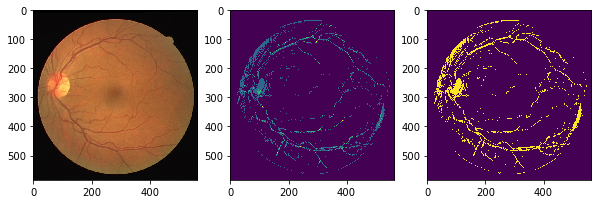

('processing image:', 1)
extraction features
features extracted
[[[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  [  1.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  [  1.00000000e+00   1.00000000e+00   1.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  ..., 
  [  8.00000000e+00   7.00000000e+00   7.00000000e+00 ...,   5.00000000e+00
     6.00000000e+00   6.00000000e+00]
  [  8.00000000e+00   8.00000000e+00   7.00000000e+00 ...,   7.00000000e+00
     7.00000000e+00   6.00000000e+00]
  [  8.00000000e+00   8.00000000e+00   8.00000000e+00 ...,   0.00000000e+00
     1.00000000e+00   0.00000000e+00]]

 [[  9.76021702e-02   6.34684100e-02   3.37698220e-02 ...,   2.28833888e-05
     1.76280757e-04   3.48150024e-04]
  [  3.03033650e-01   2.71065565e-01   2.16350427e-01 ...,   7.10470856e-04
     5.47306789e-03   1.08091703e-02]
  [  4.7481452

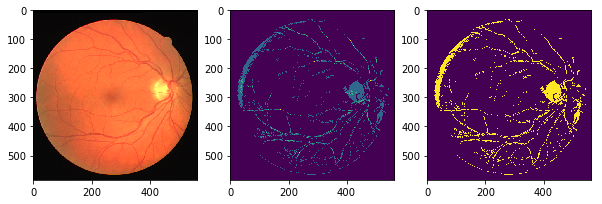

('processing image:', 2)
extraction features
features extracted
[[[  1.00000000e+00   1.00000000e+00   1.00000000e+00 ...,   2.00000000e+00
     2.00000000e+00   2.00000000e+00]
  [  1.00000000e+00   1.00000000e+00   1.00000000e+00 ...,   2.00000000e+00
     2.00000000e+00   2.00000000e+00]
  [  1.00000000e+00   1.00000000e+00   1.00000000e+00 ...,   2.00000000e+00
     2.00000000e+00   2.00000000e+00]
  ..., 
  [  7.00000000e+00   7.00000000e+00   8.00000000e+00 ...,   9.00000000e+00
     9.00000000e+00   9.00000000e+00]
  [  8.00000000e+00   8.00000000e+00   7.00000000e+00 ...,   7.00000000e+00
     7.00000000e+00   8.00000000e+00]
  [  8.00000000e+00   8.00000000e+00   7.00000000e+00 ...,   1.00000000e+00
     1.00000000e+00   1.00000000e+00]]

 [[  3.94428637e-01   5.21290990e-01   5.37759268e-01 ...,   1.07551854e+00
     1.04258198e+00   7.88857273e-01]
  [  5.21290990e-01   6.88956812e-01   7.10721877e-01 ...,   1.42144375e+00
     1.37791362e+00   1.04258198e+00]
  [  5.3775926

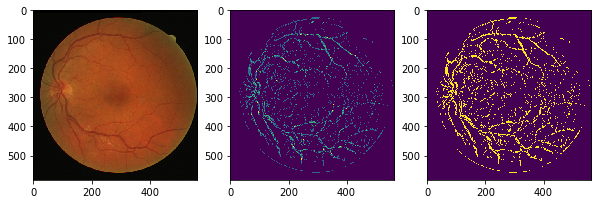

('processing image:', 3)
extraction features
features extracted
[[[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  [  1.00000000e+00   1.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   1.00000000e+00]
  ..., 
  [  7.00000000e+00   5.00000000e+00   5.00000000e+00 ...,   7.00000000e+00
     7.00000000e+00   8.00000000e+00]
  [  6.00000000e+00   6.00000000e+00   5.00000000e+00 ...,   8.00000000e+00
     8.00000000e+00   8.00000000e+00]
  [  5.00000000e+00   6.00000000e+00   6.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]]

 [[  1.57578074e-02   1.57578074e-02   5.98437460e-03 ...,   9.09635003e-04
     5.49671285e-03   1.08099318e-02]
  [  1.21389285e-01   1.21389285e-01   4.61002561e-02 ...,   1.21686749e-02
     4.68343719e-02   9.10704814e-02]
  [  2.4028883

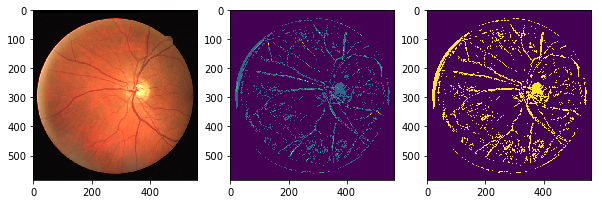

('processing image:', 4)
extraction features
features extracted
[[[  1.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   1.00000000e+00]
  ..., 
  [  8.00000000e+00   8.00000000e+00   7.00000000e+00 ...,   6.00000000e+00
     6.00000000e+00   7.00000000e+00]
  [  6.00000000e+00   7.00000000e+00   7.00000000e+00 ...,   7.00000000e+00
     7.00000000e+00   6.00000000e+00]
  [  6.00000000e+00   7.00000000e+00   8.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]]

 [[  1.59878538e-01   8.70946216e-02   5.67604405e-02 ...,   1.42170329e-03
     5.32043209e-03   1.04610202e-02]
  [  9.68916994e-02   7.25182478e-02   1.33194878e-01 ...,   1.16566066e-02
     4.13507831e-02   8.07620970e-02]
  [  1.3360963

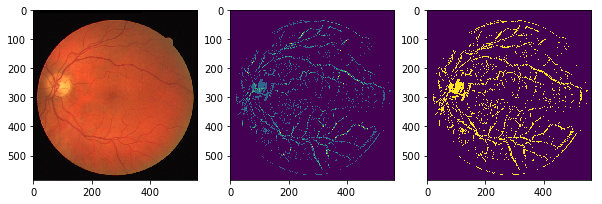

('processing image:', 5)
extraction features
features extracted
[[[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   1.00000000e+00
     0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  ..., 
  [  6.00000000e+00   6.00000000e+00   5.00000000e+00 ...,   8.00000000e+00
     7.00000000e+00   7.00000000e+00]
  [  7.00000000e+00   7.00000000e+00   7.00000000e+00 ...,   9.00000000e+00
     8.00000000e+00   6.00000000e+00]
  [  6.00000000e+00   6.00000000e+00   6.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   1.00000000e+00]]

 [[  8.84651149e-15   8.72951403e-15   8.18481085e-15 ...,   2.39740759e-01
     9.10468365e-02   1.08091703e-02]
  [  1.09129526e-14   1.03832837e-14   9.97446724e-15 ...,   1.21389285e-01
     4.61002561e-02   5.47306789e-03]
  [ -2.4750408

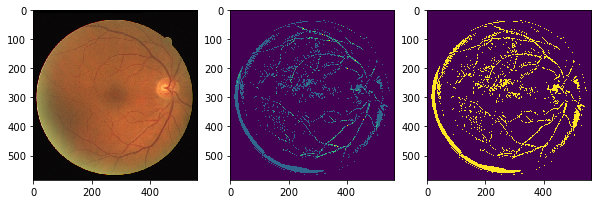

('processing image:', 6)
extraction features
features extracted
[[[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  ..., 
  [  7.00000000e+00   7.00000000e+00   7.00000000e+00 ...,   7.00000000e+00
     8.00000000e+00   7.00000000e+00]
  [  7.00000000e+00   6.00000000e+00   7.00000000e+00 ...,   7.00000000e+00
     8.00000000e+00   7.00000000e+00]
  [  7.00000000e+00   6.00000000e+00   6.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   1.00000000e+00]]

 [[  3.71794988e-04   3.75444903e-04   5.47314171e-04 ...,  -4.27990726e-15
    -4.61986575e-15  -4.52978150e-15]
  [  1.15196411e-02   1.14574425e-02   1.64682782e-02 ...,   7.40073126e-15
     7.17995862e-15   7.15253259e-15]
  [  9.6719830

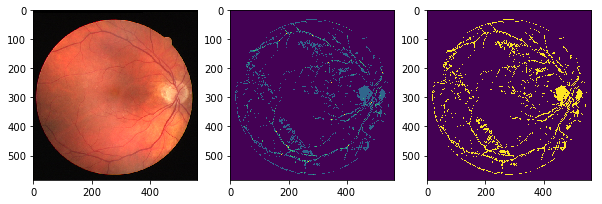

('processing image:', 7)
extraction features
features extracted
[[[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  ..., 
  [  7.00000000e+00   8.00000000e+00   9.00000000e+00 ...,   7.00000000e+00
     6.00000000e+00   9.00000000e+00]
  [  8.00000000e+00   7.00000000e+00   8.00000000e+00 ...,   7.00000000e+00
     7.00000000e+00   6.00000000e+00]
  [  9.00000000e+00   7.00000000e+00   8.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   1.00000000e+00]]

 [[ -1.28292438e-14  -1.23851546e-14  -1.20675075e-14 ...,  -3.09432704e-14
    -3.01640869e-14  -2.94876922e-14]
  [  6.74768883e-15   6.69217768e-15   6.64900234e-15 ...,  -4.22368327e-15
    -4.09462067e-15  -3.81587678e-15]
  [  3.4891159

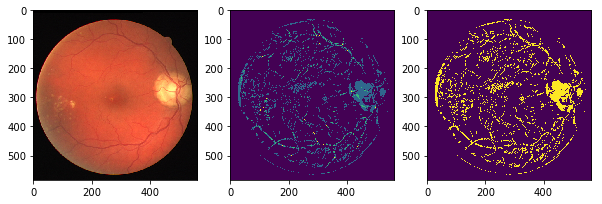

('processing image:', 8)
extraction features
features extracted
[[[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  ..., 
  [  6.00000000e+00   6.00000000e+00   6.00000000e+00 ...,   5.00000000e+00
     6.00000000e+00   7.00000000e+00]
  [  6.00000000e+00   7.00000000e+00   7.00000000e+00 ...,   7.00000000e+00
     7.00000000e+00   8.00000000e+00]
  [  7.00000000e+00   7.00000000e+00   7.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]]

 [[  9.19480541e-15   2.28833889e-05   6.87587468e-04 ...,   7.61575076e-07
    -8.90090230e-15  -7.39390946e-15]
  [  7.78389698e-15   1.76280757e-04   5.29678713e-03 ...,   2.28833888e-05
    -2.19085938e-15  -1.99339002e-15]
  [  5.2443078

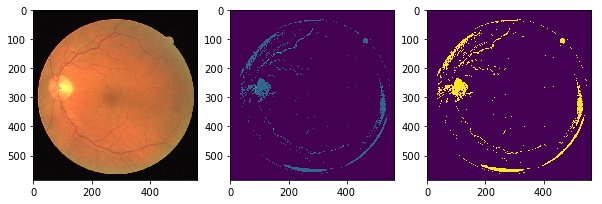

('processing image:', 9)
extraction features
features extracted
[[[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  ..., 
  [  7.00000000e+00   6.00000000e+00   6.00000000e+00 ...,   6.00000000e+00
     6.00000000e+00   5.00000000e+00]
  [  6.00000000e+00   6.00000000e+00   7.00000000e+00 ...,   8.00000000e+00
     7.00000000e+00   7.00000000e+00]
  [  6.00000000e+00   7.00000000e+00   8.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]]

 [[  5.24430782e-04   5.24430782e-04   1.99164146e-04 ...,  -3.63677952e-15
    -4.48956938e-15  -5.05735440e-15]
  [  1.57578074e-02   1.57578074e-02   5.98437460e-03 ...,  -8.97756058e-16
    -1.50093936e-15  -2.51456601e-15]
  [  1.2138928

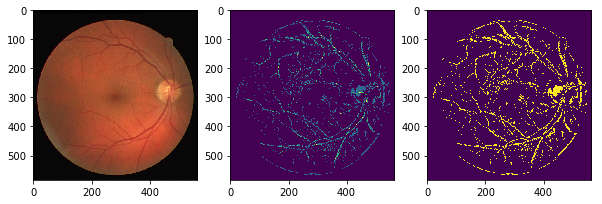

('processing image:', 10)
extraction features
features extracted
[[[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     1.00000000e+00   0.00000000e+00]
  [  1.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     1.00000000e+00   0.00000000e+00]
  [  1.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  ..., 
  [  8.00000000e+00   7.00000000e+00   6.00000000e+00 ...,   5.00000000e+00
     7.00000000e+00   7.00000000e+00]
  [  7.00000000e+00   6.00000000e+00   5.00000000e+00 ...,   6.00000000e+00
     5.00000000e+00   9.00000000e+00]
  [  9.00000000e+00   9.00000000e+00   6.00000000e+00 ...,   1.00000000e+00
     0.00000000e+00   0.00000000e+00]]

 [[  9.10475981e-02   4.61231395e-02   6.16065535e-03 ...,   1.21589211e-01
     2.39740759e-01   1.21389285e-01]
  [  2.40311718e-01   1.22800468e-01   2.17781894e-02 ...,   1.22461792e-01
     2.40265190e-01   1.21588449e-01]
  [  2.569097

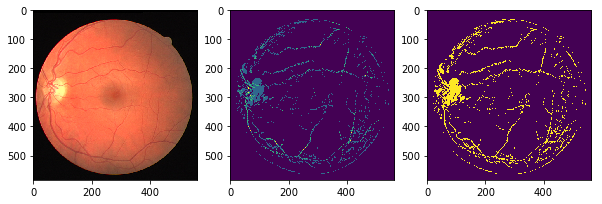

('processing image:', 11)
extraction features
features extracted
[[[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  ..., 
  [  7.00000000e+00   6.00000000e+00   6.00000000e+00 ...,   6.00000000e+00
     6.00000000e+00   1.00000000e+01]
  [  8.00000000e+00   7.00000000e+00   6.00000000e+00 ...,   8.00000000e+00
     8.00000000e+00   7.00000000e+00]
  [  9.00000000e+00   8.00000000e+00   7.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]]

 [[  1.46323443e-14   3.48150024e-04   1.04610202e-02 ...,  -3.77799135e-15
    -3.13926791e-15  -2.24338002e-15]
  [  5.24430782e-04   7.01473114e-04   5.51883466e-03 ...,  -1.11608407e-14
    -1.17925421e-14  -1.29352003e-14]
  [  1.628223

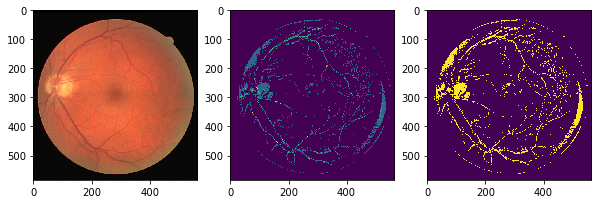

('processing image:', 12)
extraction features
features extracted
[[[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  ..., 
  [  8.00000000e+00   7.00000000e+00   7.00000000e+00 ...,   7.00000000e+00
     7.00000000e+00   7.00000000e+00]
  [  7.00000000e+00   7.00000000e+00   7.00000000e+00 ...,   8.00000000e+00
     8.00000000e+00   8.00000000e+00]
  [  7.00000000e+00   8.00000000e+00   8.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]]

 [[  2.53419688e-15   2.17769720e-15   2.34434209e-15 ...,  -1.65041824e-14
    -1.60118690e-14  -1.54712153e-14]
  [  1.35007505e-14   1.32189811e-14   1.28688020e-14 ...,   1.84448988e-16
     6.37408372e-16   8.47731439e-16]
  [  1.279034

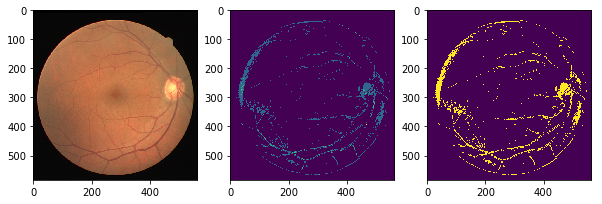

('processing image:', 13)
extraction features
features extracted
[[[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   1.00000000e+00
     1.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   1.00000000e+00
     1.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   1.00000000e+00
     1.00000000e+00   1.00000000e+00]
  ..., 
  [  7.00000000e+00   6.00000000e+00   7.00000000e+00 ...,   7.00000000e+00
     8.00000000e+00   8.00000000e+00]
  [  7.00000000e+00   6.00000000e+00   7.00000000e+00 ...,   6.00000000e+00
     6.00000000e+00   7.00000000e+00]
  [  7.00000000e+00   6.00000000e+00   6.00000000e+00 ...,   2.00000000e+00
     1.00000000e+00   0.00000000e+00]]

 [[ -3.68840760e-15   7.61575082e-07   2.36449639e-05 ...,   5.22001461e-01
     3.99901705e-01   1.54687877e-01]
  [  3.99680289e-15   2.28833888e-05   7.10470856e-04 ...,   6.94964070e-01
     5.67567527e-01   2.81550230e-01]
  [ -1.801028

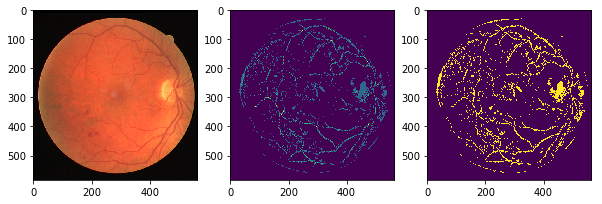

('processing image:', 14)
extraction features
features extracted
[[[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     1.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  ..., 
  [  7.00000000e+00   7.00000000e+00   7.00000000e+00 ...,   6.00000000e+00
     6.00000000e+00   5.00000000e+00]
  [  7.00000000e+00   8.00000000e+00   6.00000000e+00 ...,   6.00000000e+00
     6.00000000e+00   7.00000000e+00]
  [  5.00000000e+00   5.00000000e+00   6.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]]

 [[ -8.44925981e-15   2.36449639e-05   7.10470856e-04 ...,   5.16362842e-02
     8.09347279e-02   4.08034690e-02]
  [ -3.53555919e-15   1.99925721e-04   6.00725799e-03 ...,   8.69456358e-02
     1.59702257e-01   8.07620970e-02]
  [  2.364496

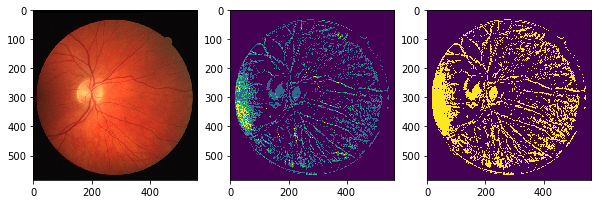

('processing image:', 15)
extraction features
features extracted
[[[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  ..., 
  [  7.00000000e+00   8.00000000e+00   8.00000000e+00 ...,   8.00000000e+00
     8.00000000e+00   8.00000000e+00]
  [  7.00000000e+00   7.00000000e+00   7.00000000e+00 ...,   7.00000000e+00
     6.00000000e+00   7.00000000e+00]
  [  9.00000000e+00   8.00000000e+00   7.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]]

 [[  1.99925721e-04   5.47314171e-04   7.00711539e-04 ...,  -9.52954634e-15
    -8.85419276e-15  -8.66772655e-15]
  [  6.55609531e-03   1.71918731e-02   2.19544702e-02 ...,  -4.33367053e-15
    -3.73784722e-15  -2.71773345e-15]
  [  6.313949

In [ ]:
# First, we will set the folder where the results will be saved
# feel free to modify this location (if you wish not to overwrite previous results)
result_output_folder = 'vessel_segmentation_results'
optimal_threshold = 0.5

if not(os.path.exists(result_output_folder)):
    os.makedirs(result_output_folder)

# Now loop over all test images
for i, (img, msk) in enumerate(zip(test_imgs, test_msks)):
    print('processing image:', i)
    raw_output, final_output = classify_img(classifier, img, msk, optimal_threshold)

    # plot the results
    matplotlib.rcParams['figure.figsize'] = (10, 6)
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.subplot(1, 3, 2)
    plt.imshow(raw_output)
    plt.subplot(1, 3, 3)
    plt.imshow(final_output)
    plt.show()

    # save the image as png file
    im = Image.fromarray(final_output.astype('uint8'))
    im.save(os.path.join(result_output_folder, "{}.png".format(i + 1)))

<p style="color:blue">Q: What is the output of your kNN classifier? Did you obtain a label for each pixel? How is that label computed?</p>


<p style="color:green">A: We obtain a high or low bit value that serves as a class label. This label is computed by the knn classifier based on the feature vectors we feed into it. It is well possibly that some of the features we compute are actually detrimental to performance.</p>

# Step 5: Submit your results!

After processing all the images in the test set you can execute the cell below to create a zip-file of the images with the segmentation results.

In [ ]:
shutil.make_archive('results', 'zip', result_output_folder)

You can now download this zipfile with this link: [results.zip](results.zip).  
Next, upload your result to the challenge website (https://drive.grand-challenge.org/evaluation/submissions/create/) and see how well you performed compared to your fellow students! You can submit as often as you want, only the best result counts.  

# Optional assignment
### Improve your results!

Try to improve your results and resubmit.

A few ideas to improve the system are:

* Change the threshold
* More training samples
* Different classifier (if you know any)
* More features (Directional filters, local binary patterns, Gabor filters, get creative!
* Postprocessing to improve the results (morphological operations), for example remove the rim around the field of view (which is obviously not part of a vessel), remove noise, etc.

## DO NOT MODIFY THE CELLS ABOVE! INSTEAD, MAKE NEW CELLS BELOW AND REUSE CODE FROM PREVIOUS CELLS!


In [ ]:
# Dear Dr. Ciompi, we did not test this against drive fully because of the time, as running locally 
# with 2000 samples already takes about an hour. If you read this please consider that we run this with less 
# samples than our top score on the normal part of the assignment.
from skimage import feature as ftr

In [ ]:
#feature selection - this time we add something ->
def extract_features_(img):
    """
        Computes features from a give input image.
        returns a Python list of feature maps (numpy arrays, the same size as the image)
        that contain the result of the convolution of each filter with the input image.
        
        As mentioned in the lecture, given the input image 'img', only the green channel
        is typically used in retina fundus image analysis. Therefore, the green channel
        is extracted, and you can use it as input for all subsequent steps in this function.
    """    
    img_green = img[:,:,1]
    # the first feature element is the green channel itself    
    features = [img_green]
    
    sigmas = [1,2,4,8,16]
    for s in sigmas:
        g = gaussian_kernel_2d(s, x0=0, y0=0, size_sigma=3)
        features.append(scipy.signal.fftconvolve(img_green, g, mode='same'))
        features.append(scipy.signal.fftconvolve(img_green, np.gradient(g,axis=0), mode='same'))
        features.append(scipy.signal.fftconvolve(img_green, np.gradient(g,axis=1), mode='same'))
        features.append(scipy.signal.fftconvolve(img_green, np.gradient(np.gradient(g,axis=0),axis=0), mode='same'))
        features.append(scipy.signal.fftconvolve(img_green, np.gradient(np.gradient(g,axis=1),axis=1), mode='same'))
        features.append(scipy.signal.fftconvolve(img_green, np.gradient(np.gradient(g,axis=1),axis=0), mode='same'))
        features.append(ftr.local_binary_pattern(img_green, 8, 3, method="uniform"))
   
    return features

In [ ]:
''' 
Pick a reasonable number for n_samples_per_class_per_image. 
More samples will likely result in better performance, but may make your method slow
10 samples per class per image is probably the minimum you need for some indicative results
if you want state of the art, you can take up to 2000 or more samples, 
but beware that this may result in long processing times
'''
n_samples_per_class_per_image = 2000
n_classes = 2 # How many classes?
n_features = 37 # How many features?

assert n_samples_per_class_per_image is not None
assert n_classes is not None
assert n_features is not None

vector_size = n_classes * n_samples_per_class_per_image # * len(train_imgs)

# x_train will contain the vector of features, extracted at <vector_size> locations in the training set
x_train = np.zeros((vector_size, n_features))
# y_train will contain the corresponding labels
y_train = np.zeros(vector_size)

In [ ]:
def classify_img_(classifier, img, msk, threshold):

    # compute features
    print('extraction features')
    features = extract_features_(img) 
    print('features extracted')

    h, w, c = img.shape
    # reshape the features to an array of feature vectors
    print(np.array(features))
    x_test = np.moveaxis(np.array(features), 0, 2).reshape((h * w, -1))
    # normalize the features
    x_test_normalized = normalization_test(x_test)

    print('classifying pixels with nearest-neighbor')
    p_test = classifier.predict_proba(x_test_normalized)
    print('classification done')

    # reshape to image format, set pixels outside the mast to zero
    p_test_reshaped = p_test[:,1].reshape(h, w) * msk

    # Threshold the probabilitymap to obtain the final result
    final_output = (p_test_reshaped > threshold) * 255 
    
    # return the raw output and the thresholded image
    return p_test_reshaped, final_output

In [ ]:
# First, we will set the folder where the results will be saved
# feel free to modify this location (if you wish not to overwrite previous results)
result_output_folder = 'vessel_segmentation_results2'
optimal_threshold = 0.5

if not(os.path.exists(result_output_folder)):
    os.makedirs(result_output_folder)

# Now loop over all test images
for i, (img, msk) in enumerate(zip(test_imgs, test_msks)):
    print('processing image:', i)
    raw_output, final_output = classify_img_(classifier, img, msk, optimal_threshold)

    # plot the results
    matplotlib.rcParams['figure.figsize'] = (10, 6)
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.subplot(1, 3, 2)
    plt.imshow(raw_output)
    plt.subplot(1, 3, 3)
    plt.imshow(final_output)
    plt.show()

    # save the image as png file
    im = Image.fromarray(final_output.astype('uint8'))
    im.save(os.path.join(result_output_folder, "{}.png".format(i + 1)))

In [ ]:
# You can add your new code here.
# Add more cells using the "+" button in the toolbar of this notebook.
# If you want to add "code" cells, select the "Code" type (default).
# If you want to add "text" cells, select the "Markdown" type.
shutil.make_archive('results', 'zip', result_output_folder)